# Speech Text Sentiment Model Finetuning 
This is a 3-Class Text Classification using the Trainer API
The Transformers library provides a lot of useful resources, like the common datasets used for various nlp tasks, and also the Trainer class, which makes the codes for fine-tuning much shorter.

# To try to fine tune small bert model variants

Version 1 (28 August 2024):
build dataset on tinybert.   
Version 2 (1st Sept 2024):  try distillbert  
Version 3 (Oct): reproduce and fine tune hyperparameter  
Version 4 (PLP further enhance): parameter efficient fine tuning    
Final: **Clean Up on the file path**  


Benchmark models here:
1. [default-distilbert-finetune-on-sst](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english/tree/main)
2. [distilbert-finetune-on-imda](https://huggingface.co/lvwerra/distilbert-imdb)
Both of them are binary classificaiton.
3. [tine-bert](https://huggingface.co/AdamCodd/tinybert-sentiment-amazon)


finetune dataset:
1. [Stanford Sentiment Treebank](https://huggingface.co/datasets/stanfordnlp/sst2)  extract from movie reviews, much short text content
2. [imda](https://huggingface.co/datasets/stanfordnlp/imdb) movie reviews

## Preparation - Set up

In [ ]:
!pip install datasets

# 1 - Data Load

This Section is to load dataset and do train-test-split.    
Besides normal splits, special session id is isolated for final domain performance test.   
As into train_dataset,  test_dataset, test_dataset_final for model training/testing comsumption

In [2]:
import pathlib
import textwrap

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.simplefilter(action='ignore') # mute warnings

import json
import time

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
import pandas as pd

data_df = pd.read_csv('/content/drive/MyDrive/IMDA_Text_processing/text_sentiment_models/IMDA_all_for_text_sentiment.csv')
data_df.head()

,session_id,x_min,speaker_id,speaker_type,dialog_type,cleaned_text_for_sentiment,word_count,rule_based_label,others_agree_with_each_other,vader_avg,textblob_avg,stanza_avg,rule_based_score,GPT4o,GPT4o_label,others_agree_with_LLM,final_sentiment_score,final_sentiment_label
0,1.0,18.58958,3002.0,client,holiday,one of the adult is wheelchair bound which is ...,13.0,neutral,True,0.0000,0.100000,0.0,0.033333,-0.15,negative,False,-0.113333,negative
1,1.0,25.79000,3002.0,client,holiday,my spouse and myself and my two children and (...,11.0,neutral,True,0.3612,0.000000,0.0,0.120400,0.00,neutral,True,0.036120,neutral
2,1.0,32.49143,3002.0,client,holiday,first for the air airplane right I would like ...,16.0,neutral,False,0.3612,0.058929,-0.8,-0.126624,0.15,neutral,True,0.150000,neutral
3,1.0,41.16000,3002.0,client,holiday,to the toilet so it s more convenient for my (...,9.0,negative,False,0.0000,0.100000,-1.0,-0.300000,0.30,neutral,False,0.300000,neutral
4,1.0,46.47164,3002.0,client,holiday,parent and also my kids because you know the t...,16.0,neutral,True,0.0000,0.000000,0.0,0.000000,0.30,neutral,True,0.210000,neutral


In [4]:
data_df = data_df[data_df.speaker_type=='client']
data_df.final_sentiment_label.value_counts()

,count
final_sentiment_label,
neutral,81460
positive,32944
negative,24023


In [5]:
# take first around 120 session id as test set
testset_df =  data_df[ (data_df.session_id>=683) & (data_df.session_id<=800)]
trainset_df = data_df[~((data_df.session_id >= 683) & (data_df.session_id <= 800))]

trainset_df = trainset_df.reset_index(drop=True)

testset_df['final_sentiment_label'].value_counts(), trainset_df['final_sentiment_label'].value_counts()

(final_sentiment_label
 neutral     4599
 negative    1261
 positive    1217
 Name: count, dtype: int64,
 final_sentiment_label
 neutral     76861
 positive    31727
 negative    22762
 Name: count, dtype: int64)

In [6]:
# data_df.word_count.max(),data_df.word_count.min()

In [7]:
df = trainset_df[['others_agree_with_LLM','cleaned_text_for_sentiment','final_sentiment_label']]
df.columns = ['agreed', 'text','label']

# Define subset size
subset_size = 30000
neutral_sample_size = subset_size

# Select all instances where 'others_agree_with_LLM' is True for negative and positive
negative_true_samples = df[(df['label'] == 'negative') & (df['agreed'] == True)]
positive_true_samples = df[(df['label'] == 'positive') & (df['agreed'] == True)]

# Calculate how many more samples are needed to reach the desired subset size
remaining_negative_needed = max(0, subset_size - len(negative_true_samples))
remaining_positive_needed = max(0, subset_size - len(positive_true_samples))

# Randomly sample additional negative and positive samples where 'others_agree_with_LLM' is False
negative_false_samples = df[(df['label'] == 'negative') & (df['agreed'] == False)].sample(
    n=remaining_negative_needed, random_state=42, replace=True)
positive_false_samples = df[(df['label'] == 'positive') & (df['agreed'] == False)].sample(
    n=remaining_positive_needed, random_state=42, replace=True)

# Combine True and False samples for negative and positive
negative_samples = pd.concat([negative_true_samples, negative_false_samples])
positive_samples = pd.concat([positive_true_samples, positive_false_samples])

# Sample neutral data
neutral_samples = df[df['label'] == 'neutral'].sample(n=neutral_sample_size, random_state=42, replace=True)

# Combine all samples into a balanced dataset
balanced_df = pd.concat([neutral_samples, positive_samples, negative_samples]).reset_index(drop=True)

# Output the final balanced dataset's class distribution
print(balanced_df['label'].value_counts())

def encode_sentiment_label(label):
    if label == 'negative':
        return 0
    elif label == 'neutral':
        return 1
    else:
        return 2

balanced_df['label'] = balanced_df['label'].apply(encode_sentiment_label)
# df.head()

label
neutral     30000
positive    30000
negative    30000
Name: count, dtype: int64


In [ ]:
import re

def clean_text_for_word_count(text):
    # Ensure the input is a string, otherwise return an empty string
    if not isinstance(text, str):
        return ''
    # Remove any string in brackets like (<xxx>) or [<xxx>] or <<xxx>>
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\<.*?\>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', text).strip()

    return cleaned_text

df['text'] = df['text'].apply(clean_text_for_word_count)
df['text'].head(10)

,text
0,one of the adult is wheelchair bound which is ...
1,my spouse and myself and my two children and I...
2,first for the air airplane right I would like ...
3,to the toilet so it s more convenient for my
4,parent and also my kids because you know the t...
5,so you know elderly they may may not be able t...
6,handicap friendly do they have facility like l...
7,and you know the restaurant is it also okay fo...
8,we also want to have some places for them you ...
9,ya so for shopping right may not be able to ma...


In [9]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=13)

# Convert the pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

### Select most agreed sample to **enhance data quality**

To prioritise choices on all-agreed samples

In [10]:
df  = testset_df[['others_agree_with_LLM','cleaned_text_for_sentiment','final_sentiment_label']]
df.columns = ['agreed', 'text','label']

# Define subset size
subset_size = 1250
neutral_sample_size = subset_size

# Select all instances where 'others_agree_with_LLM' is True for negative and positive
negative_true_samples = df[(df['label'] == 'negative') & (df['agreed'] == True)]
positive_true_samples = df[(df['label'] == 'positive') & (df['agreed'] == True)]

# Calculate how many more samples are needed to reach the desired subset size
remaining_negative_needed = max(0, subset_size - len(negative_true_samples))
remaining_positive_needed = max(0, subset_size - len(positive_true_samples))

# Randomly sample additional negative and positive samples where 'others_agree_with_LLM' is False
negative_false_samples = df[(df['label'] == 'negative') & (df['agreed'] == False)].sample(
    n=remaining_negative_needed, random_state=42, replace=True)
positive_false_samples = df[(df['label'] == 'positive') & (df['agreed'] == False)].sample(
    n=remaining_positive_needed, random_state=42, replace=True)

# Combine True and False samples for negative and positive
negative_samples = pd.concat([negative_true_samples, negative_false_samples])
positive_samples = pd.concat([positive_true_samples, positive_false_samples])

# Sample neutral data
neutral_samples = df[df['label'] == 'neutral'].sample(n=neutral_sample_size, random_state=42, replace=True)

# Combine all samples into a balanced dataset
balanced_df_test = pd.concat([neutral_samples, positive_samples, negative_samples]).reset_index(drop=True)

# Output the final balanced dataset's class distribution
print(balanced_df_test['label'].value_counts())

balanced_df_test['label'] = balanced_df_test['label'].apply(encode_sentiment_label)
balanced_df_test['text'] = balanced_df_test['text'].apply(clean_text_for_word_count)
test_dataset_final = Dataset.from_pandas(balanced_df_test)

label
neutral     1250
positive    1250
negative    1250
Name: count, dtype: int64


#  2 - Fine-tuning Model - tinybert

In [ ]:
from transformers import AutoTokenizer
# Load the tokenizer for 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

# Define a function to tokenize the dataset
def tokenize_function(examples):
    texts = examples['text'] if isinstance(examples['text'], list) else [examples['text']]
    return tokenizer(texts, padding='max_length', truncation=True, max_length=64)

# Apply the tokenizer to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/72000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [ ]:
!pip install evaluate

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate

# Load the metric
accuracy_metric = evaluate.load('accuracy')

# Define the custom compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

# Load pre-trained model for sequence classification with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=3)
# Make sure model weights are contiguous
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',        # Evaluate at the end of each epoch
    logging_strategy='epoch',           # Log at the end of each epoch
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,                   # Log every 10 steps (or adjust as needed)
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"                    # Disable reporting to external services
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics  # Pass the custom metrics function
)
import time
start = time.time()
# Train the model
trainer.train()
end = time.time()
print("tinybert model training time: ", round(end-start,3), " seconds. ")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.844100,0.755349,0.663056
2,0.747400,0.723599,0.682278
3,0.708700,0.713918,0.686111
4,0.679900,0.709092,0.693389
5,0.656500,0.707380,0.692278
6,0.638400,0.701597,0.697222
7,0.620100,0.704812,0.699500
8,0.608500,0.698594,0.702444
9,0.599900,0.703676,0.702111
10,0.593700,0.700788,0.704000


tinybert model training time:  691.184  seconds. 


In [ ]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.698594331741333, 'eval_accuracy': 0.7024444444444444, 'eval_runtime': 7.0739, 'eval_samples_per_second': 2544.563, 'eval_steps_per_second': 159.035, 'epoch': 10.0}


### Check the Accuracy and Loss Curve

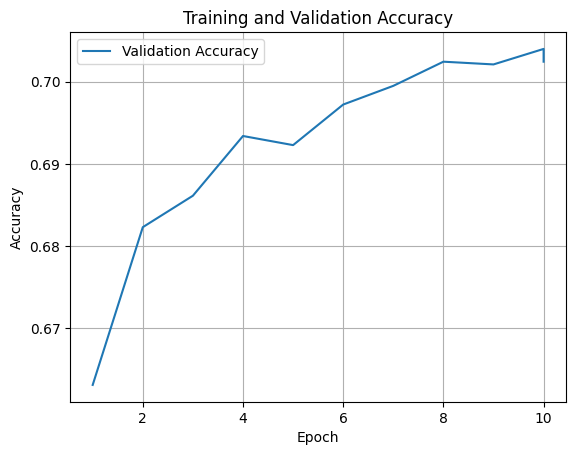

In [ ]:
# Extract the logs (Trainer already saves these logs)
train_logs = trainer.state.log_history

# Initialize lists to store training and evaluation accuracy
train_accuracy = []
eval_accuracy = []
epochs = []

# Parse the log history
for log in train_logs:
    if 'eval_accuracy' in log:  # Logs eval accuracy at the end of each epoch
        eval_accuracy.append(log['eval_accuracy'])
        epochs.append(log['epoch'])

# Plot training and validation accuracy
plt.plot(epochs, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

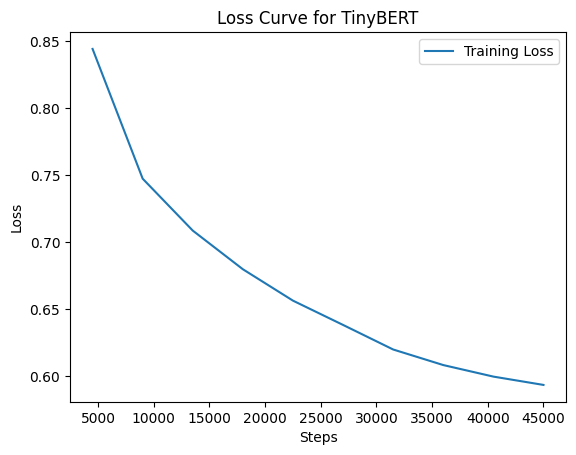

In [ ]:
loss_history = trainer.state.log_history

# Extract step numbers and loss values
steps = []
losses = []

for log in loss_history:
    if 'loss' in log:
        steps.append(log['step'])
        losses.append(log['loss'])

# Plot the loss curve
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Curve for TinyBERT")
plt.legend()
plt.show()

### Reporting

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Function to compute metrics like accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # You can choose 'macro', 'micro', or 'weighted' based on your requirement
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Predict on the training dataset
train_predictions = trainer.predict(tokenized_train_dataset)
train_accuracy = compute_metrics(train_predictions)['accuracy']
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test dataset
test_predictions = trainer.predict(tokenized_test_dataset)
test_accuracy = compute_metrics(test_predictions)['accuracy']
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.7710


Test Accuracy: 0.7024


In [ ]:
tokenized_test_dataset_final = test_dataset_final.map(tokenize_function, batched=True)
# Predict on the test dataset
test_predictions_final = trainer.predict(tokenized_test_dataset_final)
test_accuracy = compute_metrics(test_predictions_final)['accuracy']
print(f"Test Accuracy: {test_accuracy:.4f}")

test_preds_final = test_predictions_final.predictions.argmax(-1)
test_labels_final = test_predictions_final.label_ids

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

Test Accuracy: 0.6280


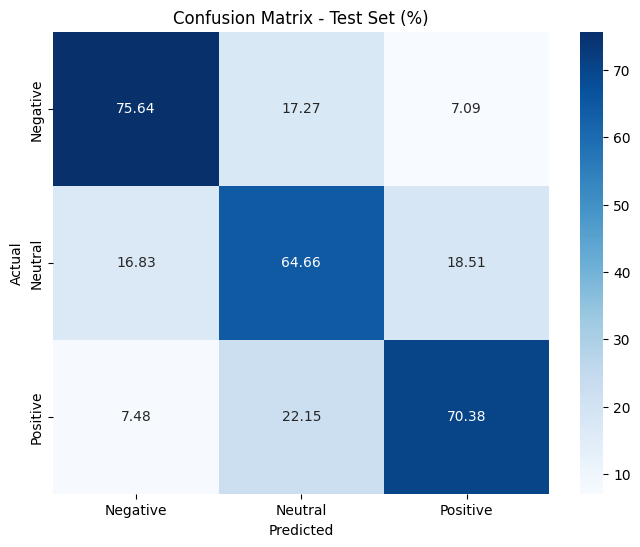

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Function to compute and plot the confusion matrix with percentages
def plot_confusion_matrix_percentage(y_true, y_pred, title='Confusion Matrix (%)'):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (actual class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Get predictions and true labels for the training set
# train_predictions = trainer.predict(tokenized_train_dataset)
train_preds = train_predictions.predictions.argmax(-1)  # Convert logits to predicted labels
train_labels = train_predictions.label_ids  # True labels

# Get predictions and true labels for the test set
# test_predictions = trainer.predict(tokenized_test_dataset)
test_preds = test_predictions.predictions.argmax(-1)
test_labels = test_predictions.label_ids

# Plot confusion matrix for training set with percentages
# plot_confusion_matrix_percentage(train_labels, train_preds, title='Confusion Matrix - Training Set (%)')

# Plot confusion matrix for test set with percentages
plot_confusion_matrix_percentage(test_labels, test_preds, title='Confusion Matrix - Test Set (%)')

In [ ]:
from sklearn.metrics import classification_report

# Print classification report for training set
print("Classification Report - Training Set")
print(classification_report(train_labels, train_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Print classification report for test set
print("Classification Report - Test Set")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

print("Classification Report - Test Set final")
print(classification_report(test_labels_final, test_preds_final, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report - Training Set
              precision    recall  f1-score   support

    Negative       0.82      0.81      0.82     24002
     Neutral       0.69      0.73      0.71     24058
    Positive       0.81      0.77      0.79     23940

    accuracy                           0.77     72000
   macro avg       0.77      0.77      0.77     72000
weighted avg       0.77      0.77      0.77     72000

Classification Report - Test Set
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76      5998
     Neutral       0.62      0.65      0.63      5942
    Positive       0.74      0.70      0.72      6060

    accuracy                           0.70     18000
   macro avg       0.70      0.70      0.70     18000
weighted avg       0.70      0.70      0.70     18000

Classification Report - Test Set final
              precision    recall  f1-score   support

    Negative       0.68      0.68      0.68      1250
     Neutral       0

In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/IMDA_Text_processing/text_sentiment_models/finetuned_tiny_bert_PLP_client_2')
tokenizer.save_pretrained('/content/drive/MyDrive/IMDA_Text_processing/text_sentiment_models/finetuned_tiny_bert_PLP_client_2')

('/content/drive/MyDrive/PLP/text_model_ZY/finetuned_tiny_bert_PLP_client_2/tokenizer_config.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_tiny_bert_PLP_client_2/special_tokens_map.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_tiny_bert_PLP_client_2/vocab.txt',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_tiny_bert_PLP_client_2/added_tokens.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_tiny_bert_PLP_client_2/tokenizer.json')

# 3 - Move on distillbert (with parameter efficient)

In [11]:
from transformers import TrainingArguments, Trainer
from accelerate import Accelerator
from transformers import AutoModelForSequenceClassification

accelerator = Accelerator()
device = accelerator.device

### Tokenization

In [14]:
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the tokenizer for 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

# Apply the tokenizer to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset_final = test_dataset_final.map(tokenize_function, batched=True)

Map:   0%|          | 0/72000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

In [15]:
# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### set up trainer

In [16]:
# Load DistilBERT model for sequence classification
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

# Load the pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Freeze all layers except for the classifier and top layers (e.g., last 2 layers)
for name, param in model.named_parameters():
    # You can choose how many layers you want to freeze.
    # For example, freeze all layers except the last 2 transformer layers and the classifier head.
    if "distilbert.transformer.layer.4" not in name and "distilbert.transformer.layer.5" not in name:
        param.requires_grad = False

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)


# Define the compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}


# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The model to be trained
    args=training_args,                  # Training arguments
    train_dataset=tokenized_train_dataset,  # Training dataset
    eval_dataset=tokenized_test_dataset,     # Evaluation dataset
    tokenizer=tokenizer,                 # The tokenizer used to preprocess the data
    data_collator=data_collator,         # The data collator for padding
    compute_metrics=compute_metrics      # Function to compute metrics
)

# Fine-tune the model
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.705600,0.693060,0.689056,0.692720,0.705630,0.689056
2,0.642000,0.647405,0.716444,0.718330,0.722633,0.716444
3,0.568000,0.626670,0.731389,0.732580,0.734883,0.731389
4,0.507200,0.625711,0.738333,0.739045,0.740056,0.738333


TrainOutput(global_step=18000, training_loss=0.6231621907552083, metrics={'train_runtime': 1064.211, 'train_samples_per_second': 270.623, 'train_steps_per_second': 16.914, 'total_flos': 4768911396864000.0, 'train_loss': 0.6231621907552083, 'epoch': 4.0})

In [17]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.6257113218307495, 'eval_accuracy': 0.7383333333333333, 'eval_f1': 0.7390448709370242, 'eval_precision': 0.7400562717568625, 'eval_recall': 0.7383333333333333, 'eval_runtime': 37.5025, 'eval_samples_per_second': 479.968, 'eval_steps_per_second': 29.998, 'epoch': 4.0}


In [18]:
# train_logs

[{'loss': 0.8511,
  'grad_norm': 2.8607709407806396,
  'learning_rate': 3.955555555555556e-05,
  'epoch': 0.1111111111111111,
  'step': 500},
 {'loss': 0.7606,
  'grad_norm': 5.273372173309326,
  'learning_rate': 3.9111111111111115e-05,
  'epoch': 0.2222222222222222,
  'step': 1000},
 {'loss': 0.7577,
  'grad_norm': 2.578252077102661,
  'learning_rate': 3.866666666666667e-05,
  'epoch': 0.3333333333333333,
  'step': 1500},
 {'loss': 0.7473,
  'grad_norm': 3.019702434539795,
  'learning_rate': 3.8222222222222226e-05,
  'epoch': 0.4444444444444444,
  'step': 2000},
 {'loss': 0.7373,
  'grad_norm': 2.8095924854278564,
  'learning_rate': 3.777777777777778e-05,
  'epoch': 0.5555555555555556,
  'step': 2500},
 {'loss': 0.74,
  'grad_norm': 2.212470531463623,
  'learning_rate': 3.733333333333334e-05,
  'epoch': 0.6666666666666666,
  'step': 3000},
 {'loss': 0.7257,
  'grad_norm': 3.8610751628875732,
  'learning_rate': 3.6888888888888896e-05,
  'epoch': 0.7777777777777778,
  'step': 3500},
 {'

### Visualization on Accuracy and loss

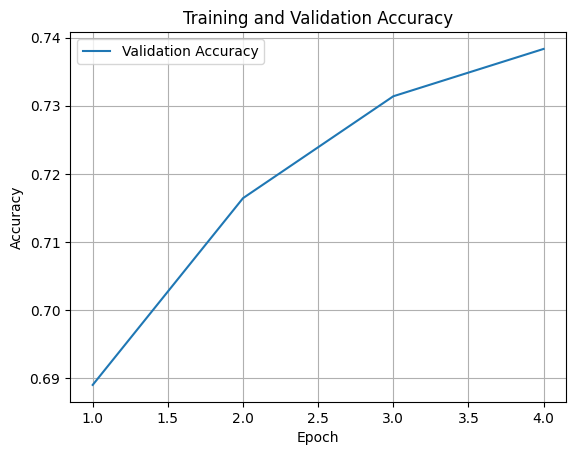

In [18]:
# Extract the logs (Trainer already saves these logs)
train_logs = trainer.state.log_history

# Initialize lists to store training and evaluation accuracy
train_accuracy = []
eval_accuracy = []
epochs = []

# Parse the log history
for log in train_logs:
    if 'eval_accuracy' in log:  # Logs eval accuracy at the end of each epoch
        eval_accuracy.append(log['eval_accuracy'])
        epochs.append(log['epoch'])

# Plot training and validation accuracy
plt.plot(epochs, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### save the model files

In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/IMDA_Text_processing/text_sentiment_models/finetuned_distilbert_client_all_19Oct3')
tokenizer.save_pretrained('/content/drive/MyDrive/IMDA_Text_processing/text_sentiment_models/finetuned_distilbert_client_all19Oct3')

('/content/drive/MyDrive/PLP/text_model_ZY/finetuned_distilbert_client_all19Oct3/tokenizer_config.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_distilbert_client_all19Oct3/special_tokens_map.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_distilbert_client_all19Oct3/vocab.txt',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_distilbert_client_all19Oct3/added_tokens.json',
 '/content/drive/MyDrive/PLP/text_model_ZY/finetuned_distilbert_client_all19Oct3/tokenizer.json')

### Evaluation Reporting 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Function to compute metrics like accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # You can choose 'macro', 'micro', or 'weighted' based on your requirement
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# Predict on the training dataset
train_predictions = trainer.predict(tokenized_train_dataset)
train_accuracy = compute_metrics(train_predictions)['accuracy']
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test dataset
test_predictions = trainer.predict(tokenized_test_dataset)
test_accuracy = compute_metrics(test_predictions)['accuracy']
print(f"Test Accuracy: {test_accuracy:.4f}")

test_predictions_final = trainer.predict(tokenized_test_dataset_final)
test_accuracy = compute_metrics(test_predictions_final)['accuracy']
print(f"Test Accuracy Final: {test_accuracy:.4f}")

In [21]:
tokenized_test_dataset_final = test_dataset_final.map(tokenize_function, batched=True)
test_predictions_final = trainer.predict(tokenized_test_dataset_final)
test_accuracy = compute_metrics(test_predictions_final)['accuracy']
print(f"Test Accuracy Final: {test_accuracy:.4f}")

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

Test Accuracy Final: 0.6515


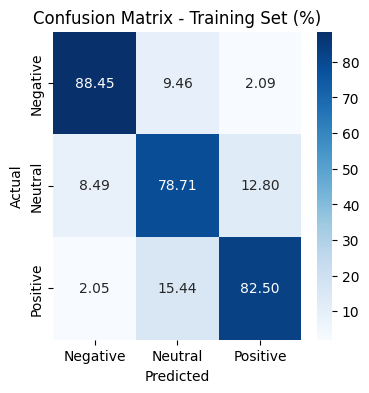

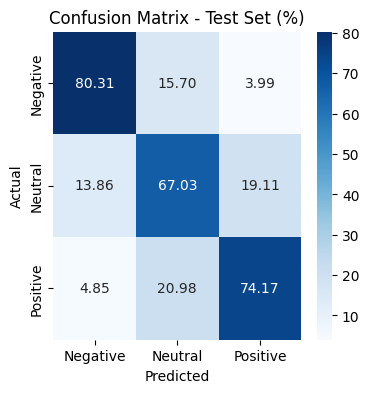

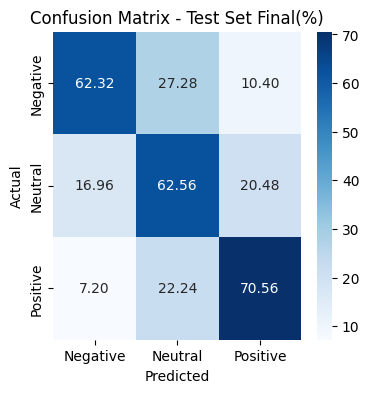

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Function to compute and plot the confusion matrix with percentages
def plot_confusion_matrix_percentage(y_true, y_pred, title='Confusion Matrix (%)'):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (actual class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Get predictions and true labels for the training set
# train_predictions = trainer.predict(tokenized_train_dataset)
# train_preds = train_predictions.predictions.argmax(-1)  # Convert logits to predicted labels
# train_labels = train_predictions.label_ids  # True labels
# test_preds = test_predictions.predictions.argmax(-1)
# test_labels = test_predictions.label_ids
# # Get predictions and true labels for the test set
# # test_predictions = trainer.predict(tokenized_test_dataset)
# test_preds_final = test_predictions_final.predictions.argmax(-1)
# test_labels_final = test_predictions_final.label_ids

# Plot confusion matrix for training set with percentages
plot_confusion_matrix_percentage(train_labels, train_preds, title='Confusion Matrix - Training Set (%)')

# Plot confusion matrix for test set with percentages
plot_confusion_matrix_percentage(test_labels, test_preds, title='Confusion Matrix - Test Set (%)')

# Plot confusion matrix for test set with percentages
plot_confusion_matrix_percentage(test_labels_final, test_preds_final, title='Confusion Matrix - Test Set Final(%)')

In [24]:
from sklearn.metrics import classification_report

# Print classification report for training set
print("Classification Report - Training Set")
print(classification_report(train_labels, train_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Print classification report for test set
print("Classification Report - Test Set")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))
test_preds_final = test_predictions_final.predictions.argmax(-1)
test_labels_final = test_predictions_final.label_ids
print("Classification Report - Test Set final")
print(classification_report(test_labels_final, test_preds_final, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report - Training Set
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     24038
     Neutral       0.76      0.79      0.77     24024
    Positive       0.85      0.83      0.84     23938

    accuracy                           0.83     72000
   macro avg       0.83      0.83      0.83     72000
weighted avg       0.83      0.83      0.83     72000

Classification Report - Test Set
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.81      5962
     Neutral       0.64      0.67      0.66      5976
    Positive       0.77      0.74      0.75      6062

    accuracy                           0.74     18000
   macro avg       0.74      0.74      0.74     18000
weighted avg       0.74      0.74      0.74     18000

Classification Report - Test Set final
              precision    recall  f1-score   support

    Negative       0.72      0.62      0.67      1250
     Neutral       0

# Reload model and inference (with trainer)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/IMDA_Text_processing/text_sentiment_models/fine_tuned_distilbert_finetuned_V3_all')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/IMDA_Text_processing/text_sentiment_models/fine_tuned_distilbert_finetuned_V3_all')

In [ ]:
# Define a function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

# Apply the tokenizer to the dataset
# tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
# tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset_final = test_dataset_final.map(tokenize_function, batched=True)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments

# Define the training arguments (required for evaluation)
training_args = TrainingArguments(
    output_dir='./results',               # Output directory
    per_device_eval_batch_size=16,        # Batch size for evaluation
    logging_dir='./logs',                 # Directory for storing logs
)

# Initialize the Trainer for evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_test_dataset_final
)

# Evaluate the model
eval_result = trainer.evaluate()

In [ ]:
print(f"Evaluation results: {eval_result}")

Evaluation results: {'eval_loss': 1.0168172121047974, 'eval_model_preparation_time': 0.0032, 'eval_runtime': 19.1355, 'eval_samples_per_second': 391.941, 'eval_steps_per_second': 24.509}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Function to compute metrics like accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # You can choose 'macro', 'micro', or 'weighted' based on your requirement
    return {
        'accuracy': accuracy,
        'f1': f1
    }

# # Predict on the training dataset
# train_predictions = trainer.predict(tokenized_train_dataset)
# train_accuracy = compute_metrics(train_predictions)['accuracy']
# print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test dataset
# test_predictions = trainer.predict(tokenized_test_dataset)
# test_accuracy = compute_metrics(test_predictions)['accuracy']
# print(f"Test Accuracy: {test_accuracy:.4f}")

test_predictions_final = trainer.predict(tokenized_test_dataset_final)
test_accuracy = compute_metrics(test_predictions_final)['accuracy']
print(f"Test Accuracy Final: {test_accuracy:.4f}")

Test Accuracy Final: 0.6315


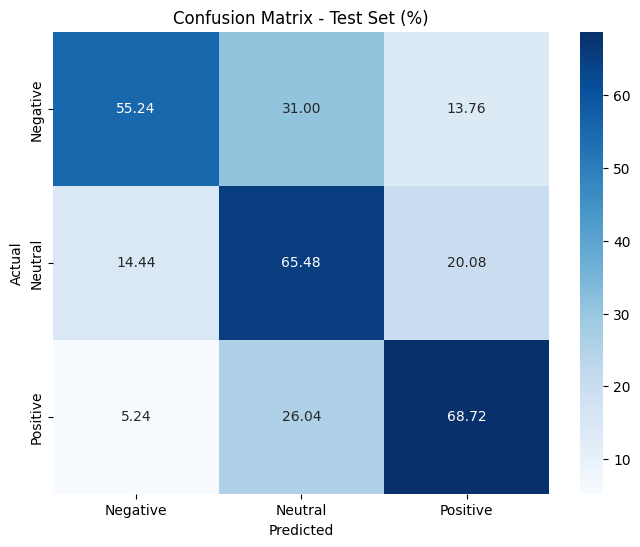

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to compute and plot the confusion matrix with percentages
def plot_confusion_matrix_percentage(y_true, y_pred, title='Confusion Matrix (%)'):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (actual class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


# Get predictions and true labels for the test set
# test_predictions = trainer.predict(tokenized_test_dataset)
test_preds = test_predictions_final.predictions.argmax(-1)
test_labels = test_predictions_final.label_ids

# Plot confusion matrix for test set with percentages
plot_confusion_matrix_percentage(test_labels, test_preds, title='Confusion Matrix - Test Set (%)')

# THE END